In [1]:
#NOTE: use paimg1 env, the retccl one has package issue with torchvision
import sys
import os
import numpy as np
import openslide
import matplotlib.pyplot as plt

import matplotlib
matplotlib.use('Agg')
import pandas as pd
import warnings
import torch
import torch.nn as nn

from sklearn.model_selection import KFold, train_test_split
from torch.utils.data import DataLoader
import torch.optim as optim
from pathlib import Path

sys.path.insert(0, '../Utils/')
from Utils import create_dir_if_not_exists
from Utils import generate_deepzoom_tiles, extract_tile_start_end_coords, get_map_startend
from Utils import get_downsample_factor
from Utils import minmax_normalize
from Utils import log_message
from Eval import compute_performance, plot_LOSS, compute_performance_each_label, get_attention_and_tileinfo, plot_predicted_tiles_with_attention
from train_utils import pull_tiles, get_feature_label_array_dynamic, get_feature_label_array_dynamic_nonoverlaptest
from train_utils import ModelReadyData_diffdim, convert_to_dict, prediction, prediction_one_mute
from Model import Mutation_MIL_ONE_MUT,Mutation_MEAMPOOLING_ONE_MUT

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
##################
###### DIR  ######
##################
proj_dir = '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/'
wsi_path = proj_dir + '/data/OPX/'
label_path = proj_dir + 'data/MutationCalls/'
model_path = proj_dir + 'models/feature_extraction_models/'
tile_path = proj_dir + 'intermediate_data/cancer_prediction_results110224/IMSIZE250_OL100/'
ft_ids_path =  proj_dir + 'intermediate_data/cd_finetune/cancer_detection_training/' #the ID used for fine-tuning cancer detection model, needs to be excluded from mutation study
feature_name = 'features_alltiles_nonoverlapretccl'
test_tile_path =  proj_dir + 'intermediate_data/cancer_prediction_results110224/IMSIZE250_OL0/'
test_feature_name = 'test_features_nonoverlapretccl'

##################
#Select GPU
##################
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
################################################
#Create output dir
################################################
SELECTED_MUTATION = "MT"
model_name = "MIL" #Chose from Linear, LinearMT
outdir0 =  proj_dir + "intermediate_data/pred_out/"
outdir1 =  outdir0  + SELECTED_MUTATION + "/saved_model/" + model_name + "/"
outdir2 =  outdir0 + SELECTED_MUTATION + "/model_para/"
outdir3 =  outdir0 + SELECTED_MUTATION + "/logs/"
outdir4 =  outdir0 + SELECTED_MUTATION + "/predictions/"


create_dir_if_not_exists(outdir0)
create_dir_if_not_exists(outdir1)
create_dir_if_not_exists(outdir2)
create_dir_if_not_exists(outdir3)
create_dir_if_not_exists(outdir4)

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out/' already exists.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out/MT/saved_model/MIL/' already exists.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out/MT/model_para/' already exists.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out/MT/logs/' already exists.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out/MT/predictions/' already exists.


In [4]:
############################################################################################################
#Select IDS
############################################################################################################
#All available IDs
opx_ids = [x.replace('.tif','') for x in os.listdir(wsi_path)] #207
opx_ids.sort()

#Get IDs that are in FT train or already processed to exclude 
ft_ids_df = pd.read_csv(ft_ids_path + 'all_tumor_fraction_info.csv')
ft_train_ids = list(ft_ids_df.loc[ft_ids_df['Train_OR_Test'] == 'Train','sample_id'])

#OPX_182 –Exclude Possible Colon AdenoCa 
toexclude_ids = ft_train_ids + ['OPX_182']  #25


#Exclude ids in ft_train or processed
selected_ids = [x for x in opx_ids if x not in toexclude_ids] #199
print(len(selected_ids))

199


In [5]:
############################################################################################################
#Get Train and test IDs, 80% - 20%
############################################################################################################
# Number of folds
n_splits = 5

# Initialize KFold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Generate the folds
train_ids_folds = []
test_ids_folds = []
for fold, (train_index, test_index) in enumerate(kf.split(selected_ids)):
    train_ids_folds.append([selected_ids[i] for i in train_index])
    test_ids_folds.append([selected_ids[i] for i in test_index])

selected_fold = 0
full_train_ids = train_ids_folds[selected_fold]
test_ids = test_ids_folds[selected_fold]

# Randomly select 5% of the train_ids for validation
train_ids, val_ids = train_test_split(full_train_ids, test_size=0.05, random_state=42)
print(len(train_ids))
print(len(val_ids))
print(len(test_ids))

151
8
40


In [6]:
############################################################################################################
#Get features and labels
#NOTE: OPX_005 has no tumor tiles, so excluded in this step
############################################################################################################
SELECTED_LABEL = ["AR","MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2","PTEN","RB1","TP53","TMB_HIGHorINTERMEDITATE","MSI_POS"]
SELECTED_LABEL = ['AR']
SELECTED_FEATURE = [str(i) for i in range(0,2048)]
TUMOR_FRAC_THRES = 0
SAMPLE_SIZE = 200
train_feature, train_label, train_info, train_tf_info = get_feature_label_array_dynamic(tile_path,feature_name, train_ids, SELECTED_LABEL,SELECTED_FEATURE,TUMOR_FRAC_THRES, SAMPLE_SIZE)
test_feature, test_label, test_info, test_tf_info = get_feature_label_array_dynamic(tile_path,feature_name, test_ids, SELECTED_LABEL,SELECTED_FEATURE,TUMOR_FRAC_THRES,SAMPLE_SIZE)
test_feature2, test_label2, = get_feature_label_array_dynamic_nonoverlaptest(test_tile_path,test_feature_name, test_ids, SELECTED_LABEL,SELECTED_FEATURE)
val_feature, val_label, val_info, val_tf_info = get_feature_label_array_dynamic(tile_path,feature_name, val_ids, SELECTED_LABEL,SELECTED_FEATURE, TUMOR_FRAC_THRES,SAMPLE_SIZE)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
0
10
20
30
0


In [7]:
# Count the number of 1s in each column
train_label_np = np.concatenate(train_label)
count_ones = np.sum(train_label_np == 1, axis=0)

print("Number of 1s in each column:", count_ones)
percentage_ones = np.round((count_ones / train_label_np.shape[0]) * 100,1)
print("% of 1s in each column:", percentage_ones)
print(["AR","HR","PTEN","RB1","TP53","TMB","MSI_POS"])

# Count the number of 1s in each column
test_label_np = np.concatenate(test_label)
count_ones = np.sum(test_label_np == 1, axis=0)

print("--------TEST------")
print("Number of 1s in each column:", count_ones)
percentage_ones = np.round((count_ones / test_label_np.shape[0]) * 100,1)
print("% of 1s in each column:", percentage_ones)
print(["AR","HR","PTEN","RB1","TP53","TMB","MSI_POS"])

Number of 1s in each column: [16]
% of 1s in each column: [10.7]
['AR', 'HR', 'PTEN', 'RB1', 'TP53', 'TMB', 'MSI_POS']
--------TEST------
Number of 1s in each column: [5]
% of 1s in each column: [12.5]
['AR', 'HR', 'PTEN', 'RB1', 'TP53', 'TMB', 'MSI_POS']


In [8]:
from sklearn.utils import resample

# Separate majority and minority classes
up_sp_perc = 0.5
X = train_feature
y = train_label

# Separate indices of each class
indices_class0 = [i for i, label in enumerate(y) if label == 0]
indices_class1 = [i for i, label in enumerate(y) if label == 1]

# Upsample indices of minority classes
n_up = int(len(indices_class0)*up_sp_perc)
indices_class1_upsampled = resample(indices_class1, replace=True, n_samples=n_up, random_state=123)

# Combine majority class indices with upsampled minority class indices
upsampled_indices = indices_class0 + indices_class1_upsampled 

#Up sampleed dataset
X_upsampled = [train_feature[i] for i in upsampled_indices]
y_upsampled = [train_label[i] for i in upsampled_indices]


# Count the number of 1s in each column
train_label_np = np.concatenate(y_upsampled)
count_ones = np.sum(train_label_np == 1, axis=0)

print("Number of 1s in each column:", count_ones)
percentage_ones = np.round((count_ones / train_label_np.shape[0]) * 100,1)
print("% of 1s in each column:", percentage_ones)
print(["AR","HR","PTEN","RB1","TP53","TMB","MSI_POS"])

Number of 1s in each column: [67]
% of 1s in each column: [33.3]
['AR', 'HR', 'PTEN', 'RB1', 'TP53', 'TMB', 'MSI_POS']


In [9]:
################################################
#     Model ready data 
################################################
train_data = ModelReadyData_diffdim(train_feature,train_label)
test_data = ModelReadyData_diffdim(test_feature,test_label)
test_data2 = ModelReadyData_diffdim(test_feature2,test_label2)
val_data = ModelReadyData_diffdim(val_feature,val_label)

####################################################
#            Train 
####################################################
LEARNING_RATE = 0.001
BATCH_SIZE  = 1
EPOCHS = 100
N_LABELS = len(SELECTED_LABEL)
                 
#Dataloader for training
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader2 = DataLoader(dataset=test_data2, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(dataset=val_data, batch_size=BATCH_SIZE, shuffle=False)


#Construct model
model = Mutation_MEAMPOOLING_ONE_MUT(in_features = 2048, act_func = 'tanh')
model.to(device)

#Optimizer
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
#optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

#Loss
loss_func = torch.nn.BCELoss()

#Model para
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")
#print(model)


#OUTPUT MODEL hyper-para
hyper_df = pd.DataFrame({"Target_Mutation": SELECTED_MUTATION,
                        #"N_Train_Patches": train_df.shape[0],
                        #"N_Train_Features": train_df.shape[1]-1,
                        #"N_Validation_Patches": val_df.shape[0],
                        "BATCH_SIZE": BATCH_SIZE,
                        "N_EPOCH": EPOCHS,
                        "Learning_Rate": LEARNING_RATE,
                        "NUM_MODEL_PARA": total_params}, index = [0])
hyper_df.to_csv(outdir2 + "hyperpara_df.csv")


log_message("Start Training", outdir3 + "training_log.txt")

Number of parameters: 2787329


Epoch0: Train-LOSS:0.66304, Valid-LOSS:0.62804
Epoch1: Train-LOSS:0.62481, Valid-LOSS:0.58096
Epoch2: Train-LOSS:0.59091, Valid-LOSS:0.53822
Epoch3: Train-LOSS:0.56056, Valid-LOSS:0.49905
Epoch4: Train-LOSS:0.53324, Valid-LOSS:0.46296
Epoch5: Train-LOSS:0.50858, Valid-LOSS:0.42958
Epoch6: Train-LOSS:0.48631, Valid-LOSS:0.39865
Epoch7: Train-LOSS:0.46624, Valid-LOSS:0.37000
Epoch8: Train-LOSS:0.44821, Valid-LOSS:0.34351
Epoch9: Train-LOSS:0.43212, Valid-LOSS:0.31910
Epoch10: Train-LOSS:0.41785, Valid-LOSS:0.29667
Epoch11: Train-LOSS:0.40529, Valid-LOSS:0.27616
Epoch12: Train-LOSS:0.39433, Valid-LOSS:0.25750
Epoch13: Train-LOSS:0.38486, Valid-LOSS:0.24061
Epoch14: Train-LOSS:0.37675, Valid-LOSS:0.22538
Epoch15: Train-LOSS:0.36986, Valid-LOSS:0.21172
Epoch16: Train-LOSS:0.36407, Valid-LOSS:0.19951
Epoch17: Train-LOSS:0.35924, Valid-LOSS:0.18865
Epoch18: Train-LOSS:0.35525, Valid-LOSS:0.17901
Epoch19: Train-LOSS:0.35197, Valid-LOSS:0.17049
Epoch20: Train-LOSS:0.34929, Valid-LOSS:0.16296
Ep

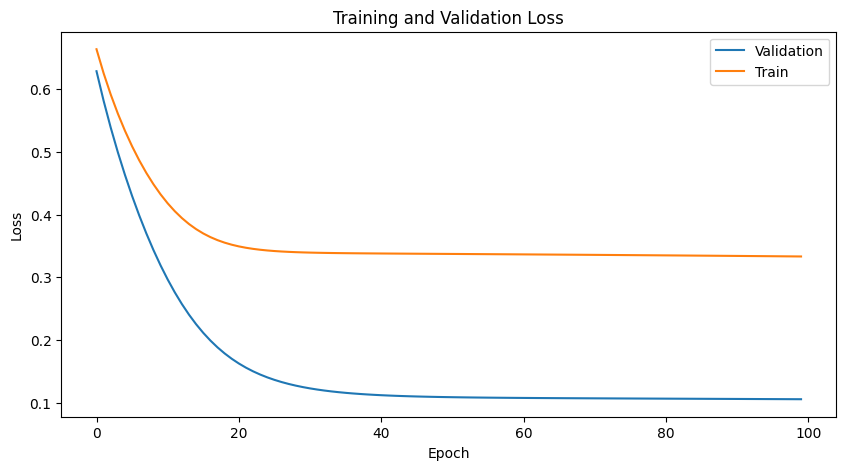

In [11]:
####################################################################################
#Training
####################################################################################
train_loss = []
valid_loss = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    ct = 0
    for x,y in train_loader:
        ct += 1
        optimizer.zero_grad() #zero the grad
        yhat  = model(x.to(device)) #Forward
        #yhat, _ = model(x.to(device)) #Forward
        
        loss = loss_func(yhat.squeeze(),y.squeeze().to(device))  #compute loss
        loss.backward() 

        #Optimize
        optimizer.step() 
        running_loss += loss.detach().item() #acuumalated average batch loss

    #Training loss 
    epoch_loss = running_loss/len(train_loader) #accumulated loss/total # batches (averaged loss over batches)
    train_loss.append(epoch_loss)

    #Validation
    model.eval()
    with torch.no_grad():
        val_running_loss = 0
        for x_val,y_val in val_loader:
            val_yhat  = model(x_val.to(device))
            #val_yhat, _ = model(x_val.to(device))
            val_loss = loss_func(val_yhat.squeeze(),y_val.squeeze().to(device))  #compute loss
            val_running_loss += val_loss.detach().item() 
        val_epoch_loss = val_running_loss/len(val_loader) 
        valid_loss.append(val_epoch_loss)
    
    print("Epoch"+ str(epoch) + ":",
          "Train-LOSS:" + "{:.5f}".format(train_loss[epoch]) + ", " +
          "Valid-LOSS:" +  "{:.5f}".format(valid_loss[epoch]))
    
    #Save model parameters
    torch.save(model.state_dict(), outdir1 + "model" + str(epoch))


#Plot LOSS
plot_LOSS(train_loss,valid_loss, outdir1)
log_message("End Training", outdir3 + "training_log.txt")

In [16]:
def prediction_one_mute(in_dataloader, in_model, n_label, loss_function, device,attention = False):
    in_model.eval()
    with torch.no_grad():
        running_loss = 0

        pred_prob_list = []
        y_true_list = []
        att_list = []
        for x,y in in_dataloader:

            #predict
            if attention == True:
                yhat, att_score = in_model(x.to(device))
                att_list.append(att_score.squeeze().cpu().numpy())
            else:
                yhat  = in_model(x.to(device))
            pred_prob_list.append(yhat.squeeze().detach().cpu().numpy())
            y_true_list.append(y.squeeze().detach().cpu().numpy())
            


            
            #Compute loss
            loss = loss_func(yhat.squeeze(),y.squeeze().to(device))  #compute loss
            running_loss += loss.detach().item() 

        #average loss across all sample
        avg_loss = running_loss/len(in_dataloader) 
        
    return pred_prob_list, y_true_list, att_list, avg_loss

        

In [17]:
####################################################################################
#Testing
####################################################################################

#Load model
min_index = valid_loss.index(min(valid_loss))
print(min_index)
model2 = Mutation_MEAMPOOLING_ONE_MUT(in_features = 2048, act_func = 'tanh')
state_dict = torch.load(outdir1 + "model" + str(min_index))
model2.load_state_dict(state_dict)
model2.to(device)


#Loss function
loss_func = torch.nn.BCELoss()
THRES = 0.1

#predicts
test_pred_prob, test_true_label, test_att, test_loss = prediction_one_mute(test_loader2, model2, N_LABELS, loss_func, device, attention = False)
print("Test-Loss TOTAL: " + "{:.5f}".format(test_loss))


#Prediction df
pred_df_list = []
for i in range(0,N_LABELS):
   pred_df_list.append(pd.DataFrame({"SAMPLE_IDs":  test_ids, 
                                          "Y_True": test_true_label, 
                                          "Pred_Prob" : test_pred_prob,
                                          "OUTCOME": SELECTED_LABEL[i]}))
pred_df = pd.concat(pred_df_list)
pred_df['Y_True'] = pred_df['Y_True'].astype(int)
#Add Predict class
pred_df['Pred_Class'] = 0
pred_df.loc[pred_df['Pred_Prob'] > THRES,'Pred_Class'] = 1
pred_df.to_csv(outdir0 + SELECTED_MUTATION + "/pred_df.csv",index = False)


#Compute performance
perf_df = compute_performance_each_label(SELECTED_LABEL, pred_df, "SAMPLE_LEVEL")
perf_df.to_csv(outdir1 + "perf.csv",index = True)

print(perf_df)
print("AVG AUC:", perf_df['AUC'].mean())

99
Test-Loss TOTAL: 0.38115
               AUC   ACC    F1    F2    F3  Recall  Precision  Specificity  \
SAMPLE_LEVEL  0.41  0.15  0.15  0.27  0.38     0.6       0.09         0.09   

                PR_AUC OUTCOME  
SAMPLE_LEVEL  0.150495      AR  
AVG AUC: 0.41


0.12956454
0.09525332


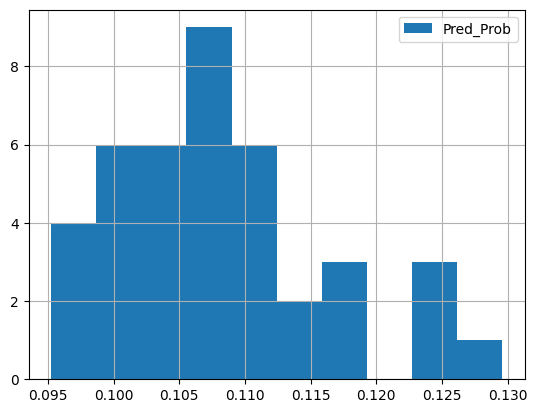

In [18]:

print(max(pred_df['Pred_Prob']))
print(min(pred_df['Pred_Prob']))
plot_df = pred_df.loc[pred_df['OUTCOME'] == 'AR']
plot_df['Pred_Prob'].hist(legend=True)
plt.show()

In [ ]:
####################################################################################
#Atention scores
####################################################################################
save_image_size = 250
pixel_overlap = 100
mag_extract = 20
limit_bounds = True
TOP_K = 5


In [ ]:
#Load slide
i = 1
pt = test_ids[i]
print(pt)

save_location =  outdir4  + pt + "/"
create_dir_if_not_exists(save_location)

_file = wsi_path + pt + ".tif"
oslide = openslide.OpenSlide(_file)
save_name = str(Path(os.path.basename(_file)).with_suffix(''))

In [ ]:
#Get a Attention, and corresponding tiles
cur_pt_att = test_att[i]
att_df = get_attention_and_tileinfo(tile_path,pretrain_model_name, pt, cur_pt_att)

In [ ]:
#TODO
#if can_proceed == True:
#Generate tiles
tiles, tile_lvls, physSize, base_mag = generate_deepzoom_tiles(oslide,save_image_size, pixel_overlap, limit_bounds)

print('starting inference')
#get level 0 size in px
l0_w = oslide.level_dimensions[0][0]
l0_h = oslide.level_dimensions[0][1]

#2.5x for probability maps
lvl_resize = get_downsample_factor(base_mag,target_magnification = mag_target_prob) #downsample factor
x_map = np.zeros((int(np.ceil(l0_h/lvl_resize)),int(np.ceil(l0_w/lvl_resize))), float)
x_count = np.zeros((int(np.ceil(l0_h/lvl_resize)),int(np.ceil(l0_w/lvl_resize))), float)


for index, row in att_df.iterrows():
    #if (index % 500 == 0): print(index)
    cur_xy = row['TILE_XY_INDEXES'].strip("()").split(", ")
    x ,y = int(cur_xy[0]) , int(cur_xy[1])
    
    #Extract tile for prediction
    lvl_in_deepzoom = tile_lvls.index(mag_extract)
    tile_starts, tile_ends, save_coords, tile_coords = extract_tile_start_end_coords(tiles, lvl_in_deepzoom, x, y) #get tile coords
    map_xstart, map_xend, map_ystart, map_yend = get_map_startend(tile_starts,tile_ends,lvl_resize) #Get current tile position in map
        
    #Store predicted probabily in map and count
    try: 
        x_count[map_xstart:map_xend,map_ystart:map_yend] += 1
        x_map[map_xstart:map_xend,map_ystart:map_yend] += row['ATT']
    except:
        pass

print('post-processing')
x_count = np.where(x_count < 1, 1, x_count)
x_map = x_map / x_count
x_map[x_map>1]=1
smooth = True
if smooth == True:
    x_sm = filters.gaussian(x_map, sigma=2)
if smooth == False:
    x_sm = x_map
cmap = plt.get_cmap('jet')
rgba_img = cmap(x_sm)
rgb_img = np.delete(rgba_img, 3, 2)
colimg = PIL.Image.fromarray(np.uint8(rgb_img * 255))
colimg
colimg.save(os.path.join(save_location, save_name + '_attention.jpeg'))

In [ ]:
#TODO2
#Generate tiles
# tiles, tile_lvls, physSize, base_mag = generate_deepzoom_tiles(oslide,save_image_size, pixel_overlap, limit_bounds)
# lvl_in_deepzoom = tile_lvls.index(mag_extract)

# #get level 0 size in px
# l0_w = oslide.level_dimensions[0][0]
# l0_h = oslide.level_dimensions[0][1]

# mag_target_prob = 2.5
# lvl_resize = get_downsample_factor(base_mag,target_magnification = mag_target_prob) #downsample factor
# heatmap = np.zeros((int(np.ceil(l0_h/lvl_resize)),int(np.ceil(l0_w/lvl_resize))), float)
# x_count = np.zeros((int(np.ceil(l0_h/lvl_resize)),int(np.ceil(l0_w/lvl_resize))), float)

In [ ]:
# #Top attented tiles
# save_location =  outdir4 + "predicted_tiles/top_tiles/" + pt + "/"
# create_dir_if_not_exists(save_location)

# #Get a Attention, and corresponding tiles
# cur_pt_att = test_att[i]
# att_df = get_attention_and_tileinfo(tile_path,pretrain_model_name, pt, cur_pt_att)
# att_df = att_df.sort_values(by = ['ATT'], ascending = False) 
# pulled_img = pull_tiles(att_df, tiles, tile_lvls)

# #Output
# plot_predicted_tiles_with_attention(att_df,pulled_img, TOP_K , save_location)


# #Bot attened tiles
# save_location =  outdir4 + "predicted_tiles/bot_tiles/" + pt + "/"
# create_dir_if_not_exists(save_location)

# #Get a Attention, and corresponding tiles
# att_df = get_attention_and_tileinfo(tile_path,pretrain_model_name, pt, cur_pt_att)
# att_df = att_df.sort_values(by = ['ATT'], ascending = True) 
# pulled_img = pull_tiles(att_df, tiles, tile_lvls)

# #Output
# plot_predicted_tiles_with_attention(att_df,pulled_img, TOP_K , save_location)

In [ ]:
# att_dict = []
# for index, row in att_df.iterrows():
#     cur_att = row['ATT']
    
#     #Get map location
#     xy = row['TILE_XY_INDEXES'].strip("()").split(", ")
#     x ,y = int(xy[0]) , int(xy[1])
#     tile_starts, tile_ends, save_coords, tile_coords = extract_tile_start_end_coords(tiles, lvl_in_deepzoom, x, y) #get tile coords
#     map_xstart, map_xend, map_ystart, map_yend = get_map_startend(tile_starts,tile_ends,lvl_resize) #Get current tile position in map
#     coords = map_xstart, map_xend, map_ystart, map_yend
#     cur_att_dict = {'coords': coords, 'att': row['ATT']}
#     att_dict.append(cur_att_dict)

In [ ]:
# %matplotlib inline
# # Map probabilities to the heatmap
# for att_coor in att_dict:
#     startx, endx, starty, endy  = att_coor['coords']
#     prob = att_coor['att']
    
#     heatmap[starty:endy+1, startx:endx+1] = prob

# # Plot the heatmap
# plt.imshow(heatmap, cmap='coolwarm', interpolation='nearest')
# plt.colorbar(label='Prediction Probability')
# plt.title('Attention Scores')
# plt.xlabel('X Coordinate')
# plt.ylabel('Y Coordinate')
# plt.show()